In [135]:
import scipy.io
import pynapple as nap
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from assembly  import runSignificance,extractPatterns,runPatterns, computeAssemblyActivity
warnings.filterwarnings("ignore")

In [45]:
def process_epochs_and_neurons(project_path,mice_name):
        
    mat_data_cell = scipy.io.loadmat(project_path+ '/'+ mice_name+'/'+'cell_id_region.mat')
    mat_data_behav = scipy.io.loadmat(project_path+ '/'+ mice_name+'/'+'behavior_times.mat')
    mat_data_spk = scipy.io.loadmat(project_path+ '/'+ mice_name+'/'+mice_name.split('_')[1]+'.spikes.cellinfo.mat')
      
    
    '''cell info'''
    cell_metrics_structure = mat_data_cell['cell_id_region']
    
    df_cell =  pd.DataFrame(cell_metrics_structure, columns=['Type', 'Region', 'Modulation'])
    
    type_map = {1: 'pyr', 2: 'int'}
    region_map = {1: 'CA1', 2: 'CA2', 3: 'CA3'}
    modulation_map = {1: 'positive', 2: 'negative'}
    
    df_cell['Type'] = df_cell['Type'].map(type_map)
    df_cell['Region'] = df_cell['Region'].map(region_map)
    df_cell['Modulation'] = df_cell['Modulation'].map(modulation_map)
    df_cell['CluID'] = list(range(0,len(df_cell)))
    
    
    ''''behv'''
    
    behavior_times = mat_data_behav['behavior_times'][0, 0].flatten()
    
    cage_or_maze = []
    start_time = []
    end_time = []
    
    
    for field_name in behavior_times.dtype.names:
        data = behavior_times[field_name][0]
        if data.size > 0:
            cage_or_maze.append(field_name)
            start_time.append(data[0][0])
            end_time.append(data[0][1])
    df_behav = pd.DataFrame({'Cage_or_Maze': cage_or_maze, 'Start_Time': start_time, 'End_Time': end_time})
    
    behav_map = {'cage1':'rest_hab_pre',
                 'maze1':'habituation_arena',
                 'cage2':'rest_hab_post',
                 'maze2':'habituation_cage',
                 'cage3':'rest_pre',
                 'maze3':'2novel_exposure',
                 'maze4':'exposure_reversed',
                 'cage4':'rest_post2',
                 'maze5':'1novel_exposure',
                 'cage5':'rest_post1'}
    
    df_behav['Cage_or_Maze'] = df_behav['Cage_or_Maze'].map(behav_map)
    
    '''spkikes'''
    
    spk_times= mat_data_spk['spikes'][0,0].flatten()
    # spikes_structure = spk_times[0]
    # spikes_dict = dict(zip(spikes_structure.dtype.names, spikes_structure))
    # spikes = spikes_dict['times'].flatten()
    
    #df_spk = pd.DataFrame(spk_times[spk_times.dtype.names[2]][0][0].flatten())
    
    list_of_dfs = [pd.DataFrame(time) for i, time in enumerate(spk_times[spk_times.dtype.names[2]][0][0].flatten())]
    df_spike_times = pd.concat(list_of_dfs, axis=1)
    
    
    
    neurons_data = nap.TsGroup({df_cell['CluID'][i]: nap.Ts(t=df_spike_times.values[:, i], time_units="s") for i in range(len(df_cell))},
                            BrainRegion= df_cell.values.T[1], 
                            CluID = df_cell.values.T[3],
                            CellType = df_cell.values.T[0])
    
    all_bincounted= {}
    all_bincounted_sorted = {}
    
    CA2_id_p = []
    CA3_id_p = []
    CA2_id_ni = []
    CA3_id_ni = []
    
    for i in range(len(df_behav)):
    
        row = df_behav.iloc[i]
        behavioral_paradigm = row['Cage_or_Maze']
        epoch = nap.IntervalSet(start=row['Start_Time'], end=row['End_Time'], time_units='s')
        ts_epoch = neurons_data.restrict(epoch)
        bincount = neurons_data.count(0.025, epoch).as_dataframe()
        if "CA3_id" not in locals():
            #Pyramidal
            try:
                CA2_spk_p = ts_epoch.getby_category("BrainRegion")["CA2"].getby_category("CellType")["pyr"]
                CA2_id_p = list(CA2_spk_p.index)
    
    
            except:
                CA2_id_p = []
                
            try:
                CA3_spk_p = ts_epoch.getby_category("BrainRegion")["CA3"].getby_category("CellType")["pyr"]
                CA3_id_p = list(CA3_spk_p.index)
            
            except:
                CA3_id_p  = []
                
            #Interneuron
            try:
                CA2_spk_ni = ts_epoch.getby_category("BrainRegion")["CA2"].getby_category("CellType")["int"]
                CA2_id_inter = list(CA2_spk_ni.index)
    
    
            except:
                CA2_id_inter = []
                
            try:
                CA3_spk_ni = ts_epoch.getby_category("BrainRegion")["CA3"].getby_category("CellType")["int"]
                CA3_id_inter = list(CA3_spk_ni.index)
            
            except:
                CA3_id_inter  = []
             
                
            
            sorted_columns =   CA2_id_p  + CA3_id_p + CA2_id_inter + CA3_id_inter 
    
            
            all_bincounted[mice_name+"_" + behavioral_paradigm] = bincount
            all_bincounted_sorted[mice_name+"_" + behavioral_paradigm ] = bincount.reindex(columns=sorted_columns)[sorted_columns]
    
    
    
    return all_bincounted_sorted, CA2_id_p, CA3_id_p,  CA2_id_inter,  CA3_id_inter


def process_session(dict_behav,ca2_id_behav, ca3_id_behav):
    correlations={}
    corr_CA2_CA3 = {}
    corr_CA2 = {}
    corr_CA3 = {}
    for behav, mat in dict_behav.items():
        correlations[behav] = mat.corr()

    def filter_corr_matrices(corr_matrix, neuron_list_region1, neuron_list_region2):
        indices_region1 = [corr_matrix.columns.get_loc(neuron) for neuron in neuron_list_region1 if neuron in corr_matrix.columns]
        indices_region2 = [corr_matrix.columns.get_loc(neuron) for neuron in neuron_list_region2 if neuron in corr_matrix.columns]

        corr_matrix_region1 = corr_matrix.iloc[indices_region1, indices_region1]
        corr_matrix_region2 = corr_matrix.iloc[indices_region2, indices_region2]
        filtered_corr_matrix = corr_matrix.iloc[indices_region1, indices_region2]

        return corr_matrix_region1, corr_matrix_region2, filtered_corr_matrix

        
    results = []
    for behav, corr_matrix in correlations.items():
        corr_matrix_CA2, corr_matrix_CA3, corr_matrix_CA2_CA3 = filter_corr_matrices(corr_matrix, ca2_id_behav, ca3_id_behav)
        corr_CA2_CA3[behav] = corr_matrix_CA2_CA3
        corr_CA2[behav]  = corr_matrix_CA2
        corr_CA3[behav] = corr_matrix_CA3
        avg_corr_CA2 = corr_matrix_CA2.mean().mean()
        avg_corr_CA3 = corr_matrix_CA3.mean().mean()
        avg_corr_CA2_CA3 = corr_matrix_CA2_CA3.mean().mean()
        results.append({'Behavior': behav, 'CA2': avg_corr_CA2, 'CA3': avg_corr_CA3, 'CA2_CA3': avg_corr_CA2_CA3})
    result_df = pd.DataFrame(results)
    result_df.set_index('Behavior', inplace=True)
    result_df = pd.DataFrame(result_df.transpose().to_dict())
    
    return corr_CA2_CA3, result_df, corr_CA2, corr_CA3

In [46]:
warnings.filterwarnings('ignore')
p_path = "D:/Research Topic/tristan/step10_olivadata"

mouse_files = [dir_name for dir_name in os.listdir(p_path)]
all_mouse = {mic: process_epochs_and_neurons(p_path,mic) for mic in mouse_files}

In [47]:
A013_day7_bins , A013_day7_ca2_p, A013_day7_ca3_p, A013_day7_ca2_inter, A013_day7_ca3_inter = process_epochs_and_neurons(p_path,'A013_day7')
A013_day13_bins , A013_day13_ca2_p, A013_day13_ca3_p, A013_day13_ca2_inter, A013_day13_ca3_inter = process_epochs_and_neurons(p_path,'A013_day13')
A013_day15_bins , A013_day15_ca2_p, A013_day15_ca3_p, A013_day15_ca2_inter, A013_day15_ca3_inter = process_epochs_and_neurons(p_path,'A013_day15')
A015_day8_bins , A015_day8_ca2_p, A015_day8_ca3_p, A015_day8_ca2_inter, A015_day8_ca3_inter = process_epochs_and_neurons(p_path,'A015_day8')
A015_day12_bins , A015_day12_ca2_p, A015_day12_ca3_p, A015_day12_ca2_inter, A015_day12_ca3_inter = process_epochs_and_neurons(p_path,'A015_day12')
AO10_day14_bins , AO10_day14_ca2_p, AO10_day14_ca3_p, AO10_day14_ca2_inter, AO10_day14_ca3_inter = process_epochs_and_neurons(p_path,'AO10_day14')
AO10_day26_bins , AO10_day26_ca2_p, AO10_day26_ca3_p, AO10_day26_ca2_inter, AO10_day26_ca3_inter = process_epochs_and_neurons(p_path,'AO10_day26')
AO12_day15_bins , AO12_day15_ca2_p, AO12_day15_ca3_p, AO12_day15_ca2_inter, AO12_day15_ca3_inter = process_epochs_and_neurons(p_path,'AO12_day15')
AO16_day12_bins , AO16_day12_ca2_p, AO16_day12_ca3_p, AO16_day12_ca2_inter, AO16_day12_ca3_inter = process_epochs_and_neurons(p_path,'AO16_day12')

In [150]:
def plot_assembly_activity(assembly_activities, epoch_names):
    num_epochs = len(epoch_names)
    fig, axs = plt.subplots(1, num_epochs, figsize=(20, 5))
    for i, (epoch_name, activity) in enumerate(assembly_activities.items()):
        plt.style.use('seaborn-v0_8-pastel')
        csfont = {'fontname':'Comic Sans MS'}
        hfont = {'fontname':'Helvetica'}
        time_values = np.arange(activity.shape[1]) / 1000  # Convert time to seconds
        axs[i].plot(time_values, activity.T)
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Assembly Activity')
        axs[i].set_title(f'Activity in {epoch_name}')
        #axs[i].legend(range(len(activity)), loc='upper right')
        #axs[0].format(xticks=20, xtickminor=False) 
        #axs.format(suptitle='ProPlot API', title='Title',
           #xlabel='x axis', ylabel='y axis')
        axs[i].grid(False)
        axs[i].text(-0.1, 1.05, chr(65+i), transform=axs[i].transAxes, size=20, weight='bold')
    plt.tight_layout()
    plt.show()

def plot_assembly_patterns(patterns, epoch_names):
    for epoch_name, pattern_set in patterns.items():
        plt.style.use('seaborn-v0_8-pastel')
        num_neurons = len(pattern_set[0])
        threshold = 1/num_neurons
        num_assemblies = len(pattern_set)
        num_cols = num_assemblies
        num_rows = 1
        
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5))
        if num_assemblies == 1:
            axs = [axs]  # Make axs iterable if it's a single subplot
        
        for j, pattern in enumerate(pattern_set):
            axs[j].stem(pattern, linefmt='-', markerfmt='o', basefmt=' ', label=f'Assembly {j + 1}')
            axs[j].axhline(y=threshold, color='r', linestyle='--', label='Threshold')
            axs[j].set_xlabel('Neuron')
            axs[j].set_ylabel('Activation')
            axs[j].set_title(f'Pattern {j + 1}')
            axs[j].legend()
            axs[j].grid(False)
            axs[j].text(-0.1, 1.05, chr(65+j), transform=axs[j].transAxes, size=20, weight='bold')
        plt.suptitle(f'Patterns in {epoch_name}')
        plt.tight_layout()
        plt.show()
        
        # Print neurons above the threshold
        for j, pattern in enumerate(pattern_set):
            above_threshold = np.where(pattern > threshold)[0]
            print(f"Epoch: {epoch_name}, Assembly {j + 1} - Neurons above threshold: {above_threshold}")

def plot_combined_assembly_activity(assembly_activities, epoch_names):
    plt.figure(figsize=(12, 6))
    for epoch_name, activity in assembly_activities.items():
        for i in range(activity.shape[0]):
            plt.style.use('seaborn-v0_8-pastel')
            time_values = np.arange(activity.shape[1]) / 1000
            plt.plot(time_values, activity[i], label=f'{epoch_name} - Assembly {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Assembly Activity')
    plt.title('Combined Assembly Activity across Epochs')
    plt.legend(loc='upper right')
    plt.grid(False)
    plt.show()

def plot_assembly_patterns(patterns, epoch_names, ca2_indices, ca3_indices, ca1_indices):
    assembly_counts = {'CA1 only': [], 'CA2 only': [], 'CA3 only': [], 'CA2-CA3': [],  'CA1-CA2': []}
    
    for epoch_name, pattern_set in patterns.items():
        plt.style.use('seaborn-v0_8-pastel')
        num_neurons = len(pattern_set[0])
        threshold = 1/num_neurons
        num_assemblies = len(pattern_set)
        num_cols = num_assemblies
        num_rows = 1
        
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5))
        if num_assemblies == 1:
            axs = [axs]  # Make axs iterable if it's a single subplot
        
        ca2_count = 0
        ca3_count = 0
        ca2_ca3_count = 0
        
        for j, pattern in enumerate(pattern_set):
            axs[j].stem(pattern, linefmt='-', markerfmt='o', basefmt=' ', label=f'Assembly {j + 1}')
            axs[j].axhline(y=threshold, color='r', linestyle='--', label='Threshold')
            axs[j].set_xlabel('Neuron')
            axs[j].set_ylabel('Activation')
            axs[j].set_title(f'Pattern {j + 1}')
            axs[j].legend()
            axs[j].grid(False)
            axs[j].text(-0.1, 1.05, chr(65+j), transform=axs[j].transAxes, size=20, weight='bold')
        plt.suptitle(f'Patterns in {epoch_name}')
        plt.tight_layout()
        plt.show()
        
        # Print neurons above the threshold and check their regions
        for j, pattern in enumerate(pattern_set):
            above_threshold = np.where(pattern > threshold)[0]
            print(f"Epoch: {epoch_name}, Assembly {j + 1} - Neurons above threshold: {above_threshold}")
            
            if any(neuron in ca2_indices for neuron in above_threshold):
                if all(neuron in ca2_indices for neuron in above_threshold):
                    ca2_count += 1
                elif any(neuron in ca3_indices for neuron in above_threshold):
                    ca2_ca3_count += 1
                elif any(neuron in ca1_indices for neuron in above_threshold):
                    ca1_ca2_count += 1
            elif all(neuron in ca3_indices for neuron in above_threshold):
                ca3_count += 1
            elif all(neuron in ca1_indices for neuron in above_threshold):
                ca1_count += 1
        assembly_counts['CA1 only'].append(ca1_count)
        assembly_counts['CA2 only'].append(ca2_count)
        assembly_counts['CA3 only'].append(ca3_count)
        assembly_counts['CA2-CA3'].append(ca2_ca3_count)
        assembly_counts['CA1-CA2'].append(ca1_ca2_count)
    
    return assembly_counts

def plot_assembly_counts(assembly_counts, epoch_names):
    labels = epoch_names
    ca1_only = assembly_counts['CA1 only']
    ca2_only = assembly_counts['CA2 only']
    ca3_only = assembly_counts['CA3 only']
    ca2_ca3 = assembly_counts['CA2-CA3']
    ca1_ca2 = assembly_counts['CA1-CA2']

    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - 2 * width, ca2_only, width, label='CA1 only')
    rects2 = ax.bar(x - width, ca2_only, width, label='CA2 only')
    rects3 = ax.bar(x, ca3_only, width, label='CA3 only')
    rects4 = ax.bar(x + width, ca2_ca3, width, label='CA2-CA3')
    rects5 = ax.bar(x + 2 * width, ca1_ca2, width, label='CA2-CA3')
   

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Number of Assemblies')
    ax.set_title('Number of Assemblies by Region and Epoch')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.xticks()
    fig.tight_layout()
    plt.show()

# During Rest epochs

In [122]:
include_epoch = {'AO16_day12_rest_hab_pre', 'AO16_day12_rest_hab_post', 'AO16_day12_rest_pre', 'AO16_day12_rest_post2'}
A016_day12 = dict(filter(lambda item: item[0] in include_epoch, AO16_day12_bins.items()))
assembly_activities = {}
patterns = {}
zactmats = {}

for epoch_name, epoch_data in A016_day12.items():
    # Run the function for cell assemblies (replace with actual function call and parameters)
    patterns_epoch, significance, zactmat = runPatterns(epoch_data.values.T, method='ica', nullhyp='mp')
    assembly_activity = computeAssemblyActivity(patterns_epoch, zactmat)
    
    # Store results
    assembly_activities[epoch_name] = assembly_activity
    patterns[epoch_name] = patterns_epoch
    zactmats[epoch_name] = zactmat

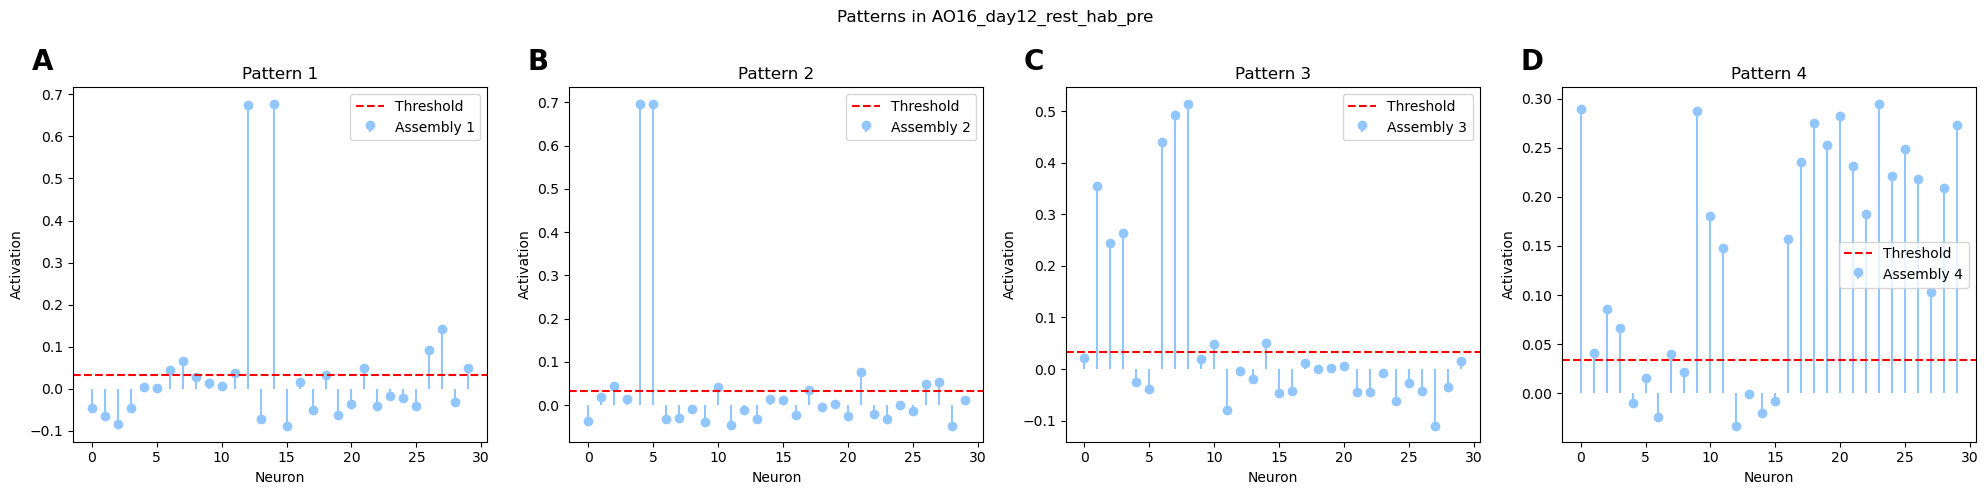

Epoch: AO16_day12_rest_hab_pre, Assembly 1 - Neurons above threshold: [ 6  7 11 12 14 21 26 27 29]
Epoch: AO16_day12_rest_hab_pre, Assembly 2 - Neurons above threshold: [ 2  4  5 10 17 21 26 27]
Epoch: AO16_day12_rest_hab_pre, Assembly 3 - Neurons above threshold: [ 1  2  3  6  7  8 10 14]
Epoch: AO16_day12_rest_hab_pre, Assembly 4 - Neurons above threshold: [ 0  1  2  3  7  9 10 11 16 17 18 19 20 21 22 23 24 25 26 27 28 29]


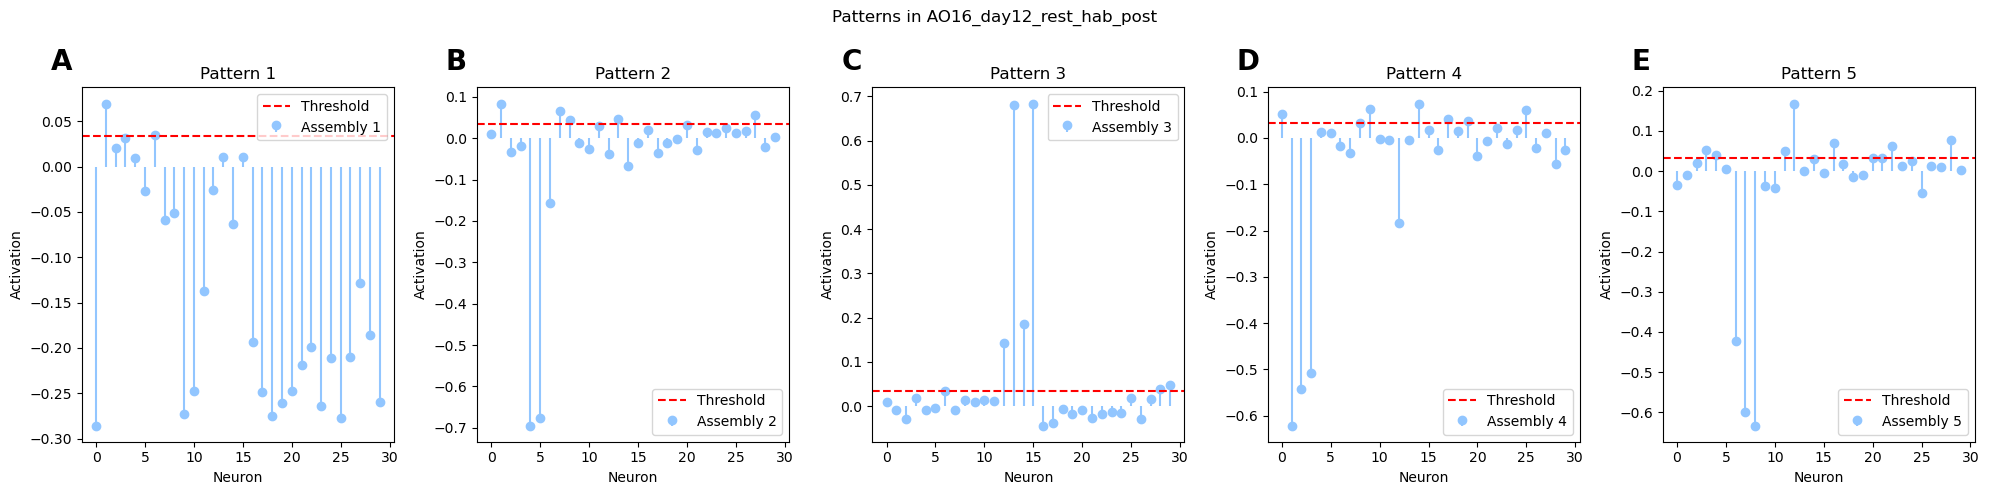

Epoch: AO16_day12_rest_hab_post, Assembly 1 - Neurons above threshold: [1 6]
Epoch: AO16_day12_rest_hab_post, Assembly 2 - Neurons above threshold: [ 1  7  8 13 27]
Epoch: AO16_day12_rest_hab_post, Assembly 3 - Neurons above threshold: [ 6 12 13 14 15 28 29]
Epoch: AO16_day12_rest_hab_post, Assembly 4 - Neurons above threshold: [ 0  9 14 17 19 25]
Epoch: AO16_day12_rest_hab_post, Assembly 5 - Neurons above threshold: [ 3  4 11 12 16 22 28]


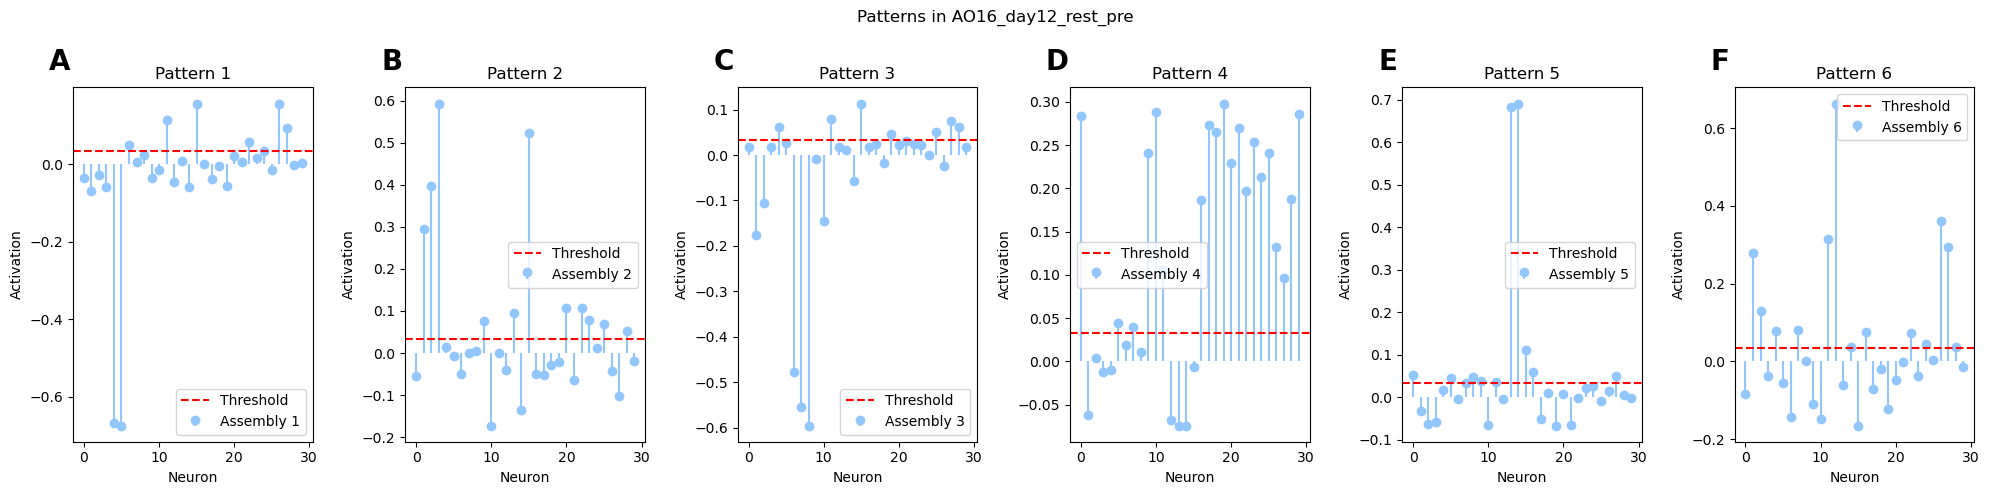

Epoch: AO16_day12_rest_pre, Assembly 1 - Neurons above threshold: [ 6 11 15 22 24 26 27]
Epoch: AO16_day12_rest_pre, Assembly 2 - Neurons above threshold: [ 1  2  3  9 13 15 20 22 23 25 28]
Epoch: AO16_day12_rest_pre, Assembly 3 - Neurons above threshold: [ 4 11 15 19 25 27 28]
Epoch: AO16_day12_rest_pre, Assembly 4 - Neurons above threshold: [ 0  5  7  9 10 11 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
Epoch: AO16_day12_rest_pre, Assembly 5 - Neurons above threshold: [ 0  5  7  8  9 11 13 14 15 16 27]
Epoch: AO16_day12_rest_pre, Assembly 6 - Neurons above threshold: [ 1  2  4  7 11 12 14 16 22 24 26 27 28]


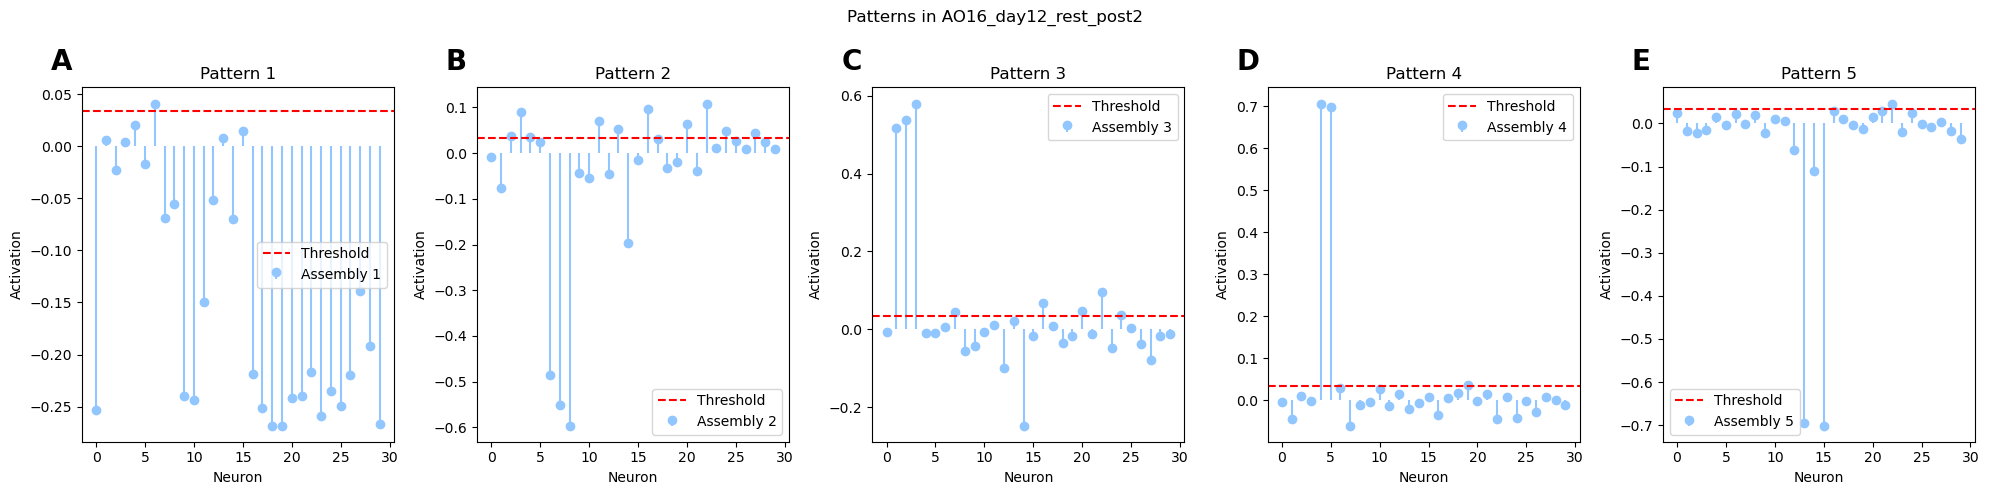

Epoch: AO16_day12_rest_post2, Assembly 1 - Neurons above threshold: [6]
Epoch: AO16_day12_rest_post2, Assembly 2 - Neurons above threshold: [ 2  3  4 11 13 16 20 22 24 27]
Epoch: AO16_day12_rest_post2, Assembly 3 - Neurons above threshold: [ 1  2  3  7 16 20 22 24]
Epoch: AO16_day12_rest_post2, Assembly 4 - Neurons above threshold: [ 4  5 19]
Epoch: AO16_day12_rest_post2, Assembly 5 - Neurons above threshold: [22]


In [131]:
assembly_counts = plot_assembly_patterns(patterns, list(A016_day12.keys()), AO16_day12_ca2_p, AO16_day12_ca3_p)
plot_assembly_counts(assembly_counts, list(A016_day12.keys()))

In [ ]:
include_epoch = {'AO12_day15_rest_hab_pre', 'AO12_day15_rest_hab_post', 'AO12_day15_rest_pre', 'AO12_day15_rest_post2'}
AO12_day15 = dict(filter(lambda item: item[0] in include_epoch, AO12_day15_bins.items()))
assembly_activities = {}
patterns = {}
zactmats = {}

for epoch_name, epoch_data in AO12_day15.items():
    # Run the function for cell assemblies (replace with actual function call and parameters)
    patterns_epoch, significance, zactmat = runPatterns(epoch_data.values.T, method='ica', nullhyp='mp')
    assembly_activity = computeAssemblyActivity(patterns_epoch, zactmat)
    
    # Store results
    assembly_activities[epoch_name] = assembly_activity
    patterns[epoch_name] = patterns_epoch
    zactmats[epoch_name] = zactmat

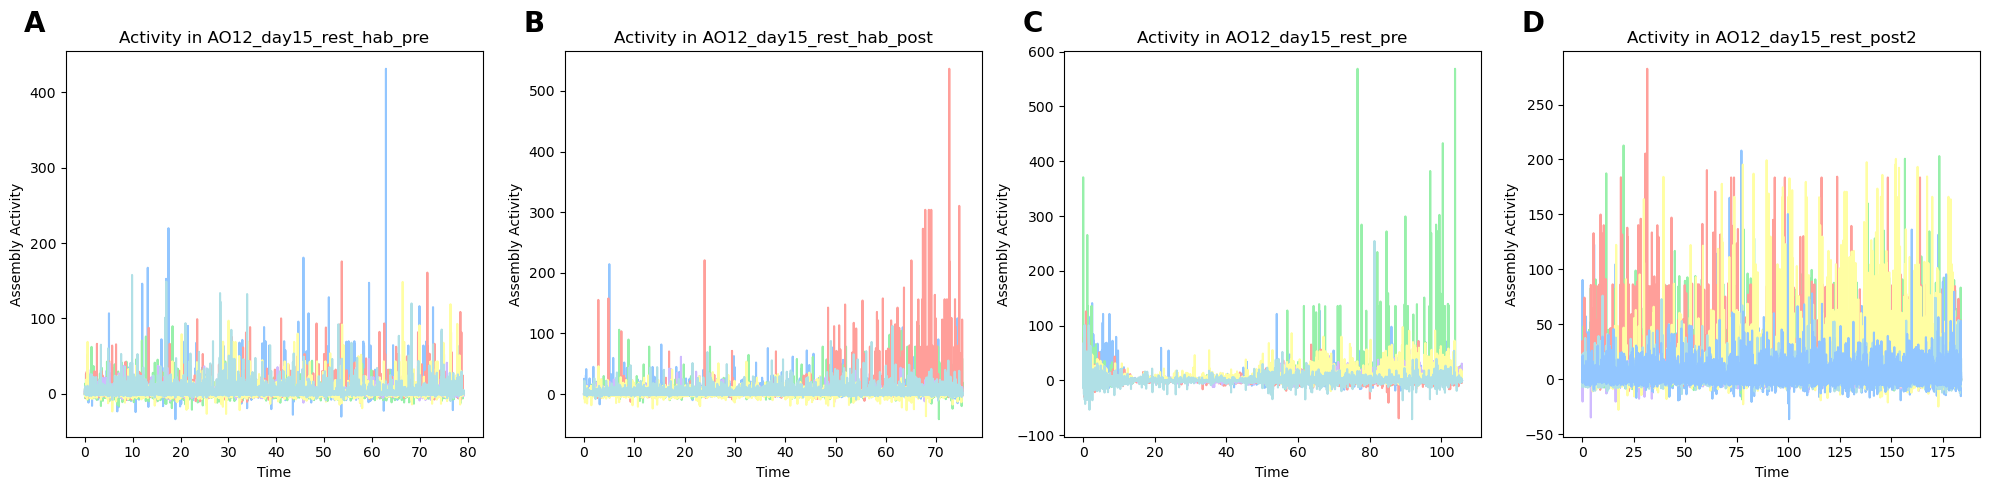

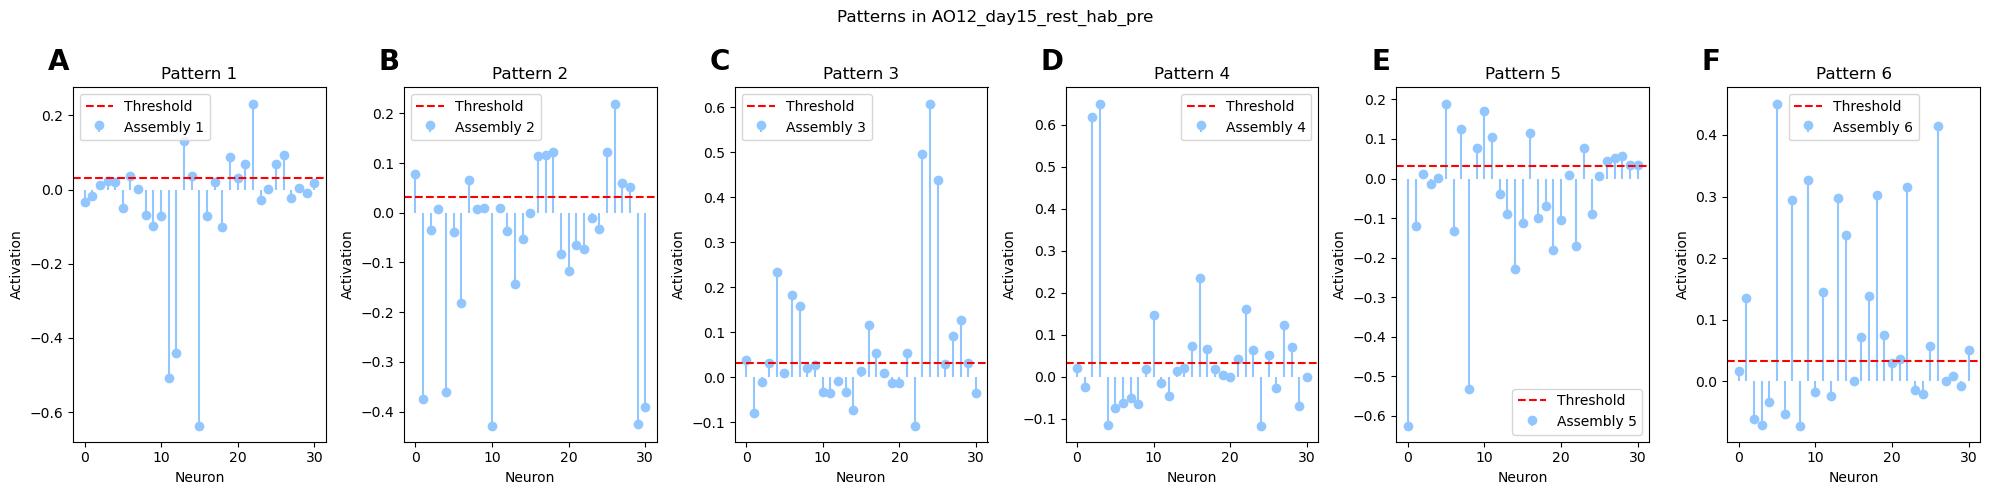

Epoch: AO12_day15_rest_hab_pre, Assembly 1 - Neurons above threshold: [ 6 13 14 19 21 22 25 26]
Epoch: AO12_day15_rest_hab_pre, Assembly 2 - Neurons above threshold: [ 0  7 16 17 18 25 26 27 28]
Epoch: AO12_day15_rest_hab_pre, Assembly 3 - Neurons above threshold: [ 0  4  6  7 16 17 21 23 24 25 27 28]
Epoch: AO12_day15_rest_hab_pre, Assembly 4 - Neurons above threshold: [ 2  3 10 15 16 17 21 22 23 25 27 28]
Epoch: AO12_day15_rest_hab_pre, Assembly 5 - Neurons above threshold: [ 5  7  9 10 11 16 23 26 27 28 29 30]
Epoch: AO12_day15_rest_hab_pre, Assembly 6 - Neurons above threshold: [ 1  5  7  9 11 13 14 16 17 18 19 21 22 25 26 30]


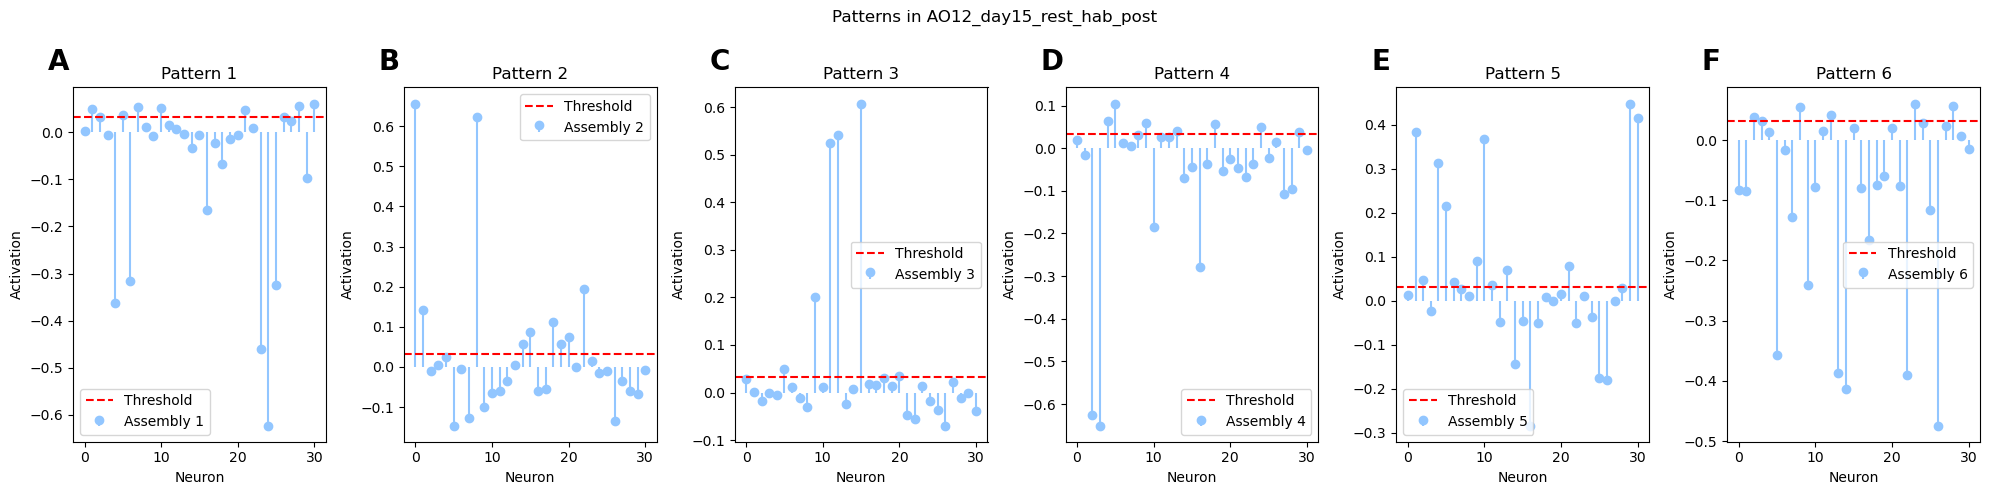

Epoch: AO12_day15_rest_hab_post, Assembly 1 - Neurons above threshold: [ 1  2  5  7 10 21 28 30]
Epoch: AO12_day15_rest_hab_post, Assembly 2 - Neurons above threshold: [ 0  1  8 14 15 18 19 20 22]
Epoch: AO12_day15_rest_hab_post, Assembly 3 - Neurons above threshold: [ 5  9 11 12 15 20]
Epoch: AO12_day15_rest_hab_post, Assembly 4 - Neurons above threshold: [ 4  5  9 13 18 24 29]
Epoch: AO12_day15_rest_hab_post, Assembly 5 - Neurons above threshold: [ 1  2  4  5  6  9 10 11 13 21 29 30]
Epoch: AO12_day15_rest_hab_post, Assembly 6 - Neurons above threshold: [ 2  3  8 12 23 28]


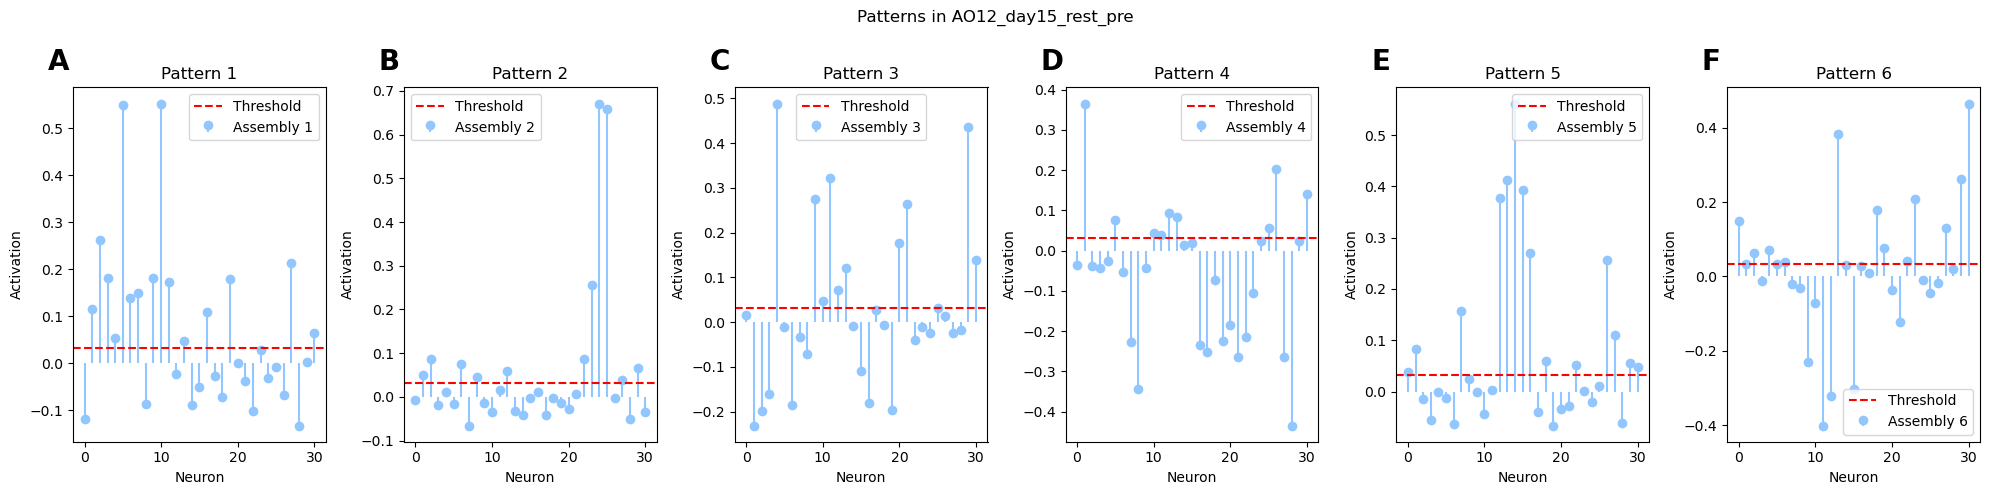

Epoch: AO12_day15_rest_pre, Assembly 1 - Neurons above threshold: [ 1  2  3  4  5  6  7  9 10 11 13 16 19 27 30]
Epoch: AO12_day15_rest_pre, Assembly 2 - Neurons above threshold: [ 1  2  6  8 12 22 23 24 25 27 29]
Epoch: AO12_day15_rest_pre, Assembly 3 - Neurons above threshold: [ 4  9 10 11 12 13 20 21 29 30]
Epoch: AO12_day15_rest_pre, Assembly 4 - Neurons above threshold: [ 1  5 10 11 12 13 25 26 30]
Epoch: AO12_day15_rest_pre, Assembly 5 - Neurons above threshold: [ 0  1  7 12 13 14 15 16 18 22 26 27 29 30]
Epoch: AO12_day15_rest_pre, Assembly 6 - Neurons above threshold: [ 0  1  2  4  5  6 13 18 19 22 23 27 29 30]


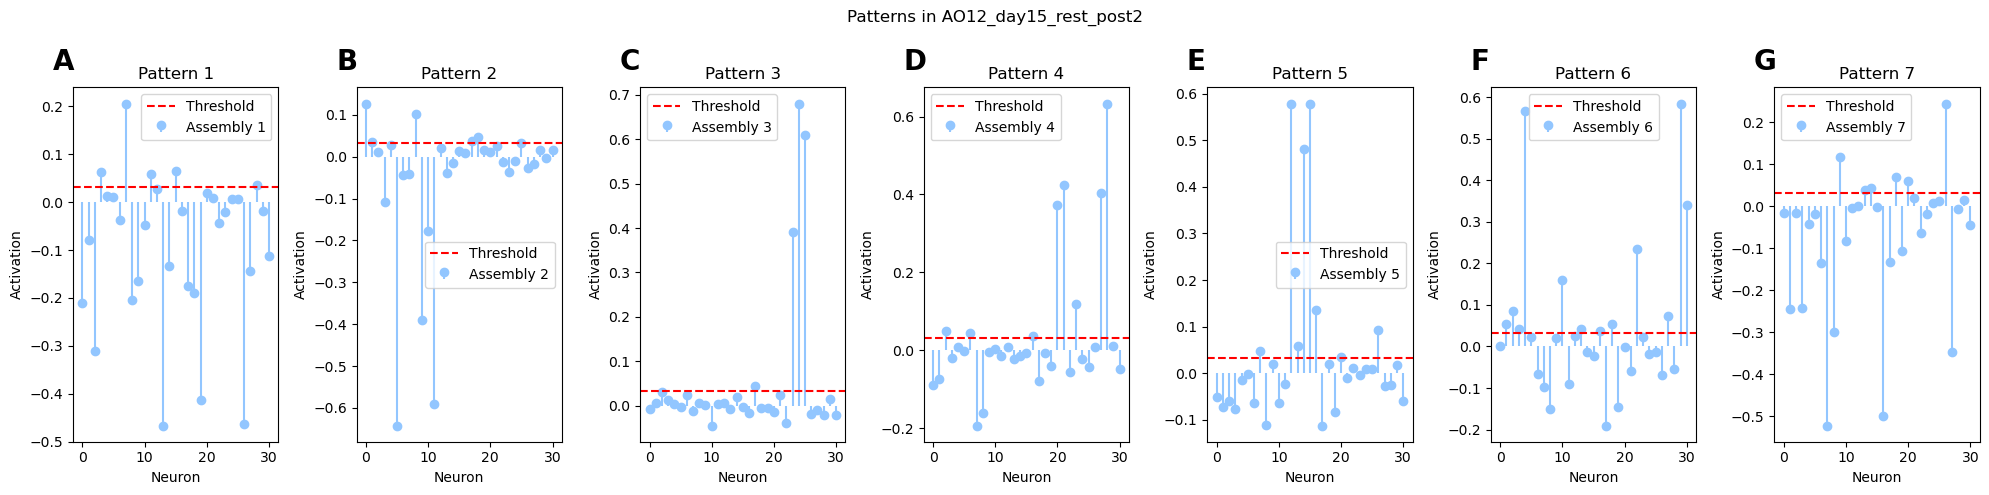

Epoch: AO12_day15_rest_post2, Assembly 1 - Neurons above threshold: [ 3  7 11 15 28]
Epoch: AO12_day15_rest_post2, Assembly 2 - Neurons above threshold: [ 0  1  8 17 18 25]
Epoch: AO12_day15_rest_post2, Assembly 3 - Neurons above threshold: [17 23 24 25]
Epoch: AO12_day15_rest_post2, Assembly 4 - Neurons above threshold: [ 2  6 16 20 21 23 27 28]
Epoch: AO12_day15_rest_post2, Assembly 5 - Neurons above threshold: [ 7 12 13 14 15 16 20 26]
Epoch: AO12_day15_rest_post2, Assembly 6 - Neurons above threshold: [ 1  2  3  4 10 13 16 18 22 27 29 30]
Epoch: AO12_day15_rest_post2, Assembly 7 - Neurons above threshold: [ 9 13 14 18 20 26]


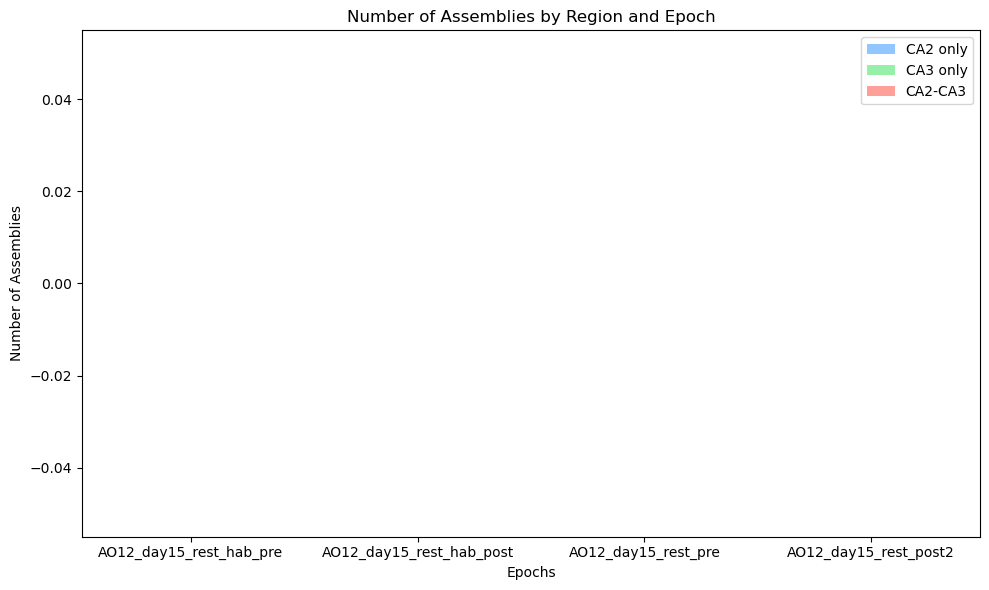

In [137]:
# Plot the assembly activities
#plot_assembly_activity(assembly_activities, list(AO12_day15.keys()))
assembly_counts = plot_assembly_patterns(patterns, list(AO12_day15.keys()), AO12_day15_ca2_p, AO12_day15_ca3_p)
plot_assembly_counts(assembly_counts, list(AO12_day15.keys()))

In [144]:
include_epoch = {'AO10_day14_rest_hab_pre', 'AO10_day14_rest_hab_post', 'AO10_day14_rest_pre', 'AO10_day14_rest_post2'}
AO10_day14 = dict(filter(lambda item: item[0] in include_epoch, AO10_day14_bins.items()))
assembly_activities = {}
patterns = {}
zactmats = {}

for epoch_name, epoch_data in AO10_day14.items():
    # Run the function for cell assemblies (replace with actual function call and parameters)
    patterns_epoch, significance, zactmat = runPatterns(epoch_data.values.T, method='ica', nullhyp='mp')
    assembly_activity = computeAssemblyActivity(patterns_epoch, zactmat)
    
    # Store results
    assembly_activities[epoch_name] = assembly_activity
    patterns[epoch_name] = patterns_epoch
    zactmats[epoch_name] = zactmat

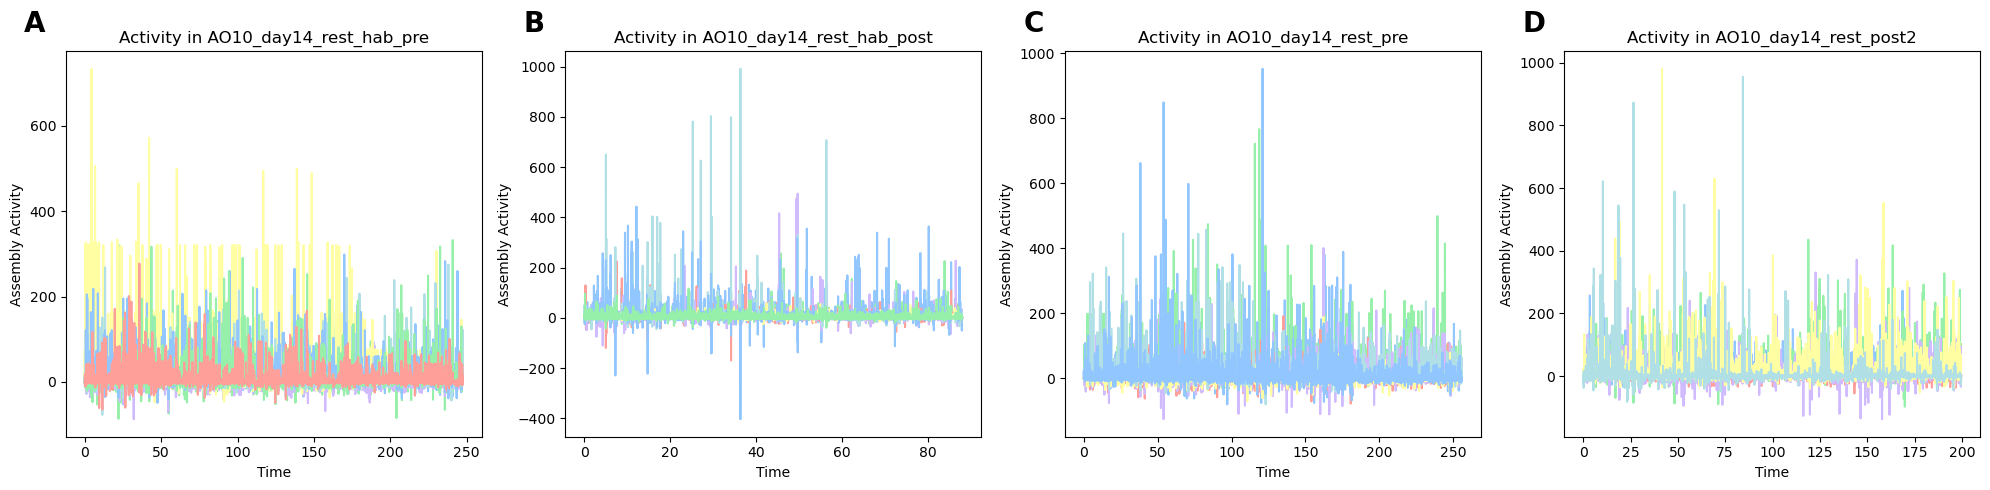

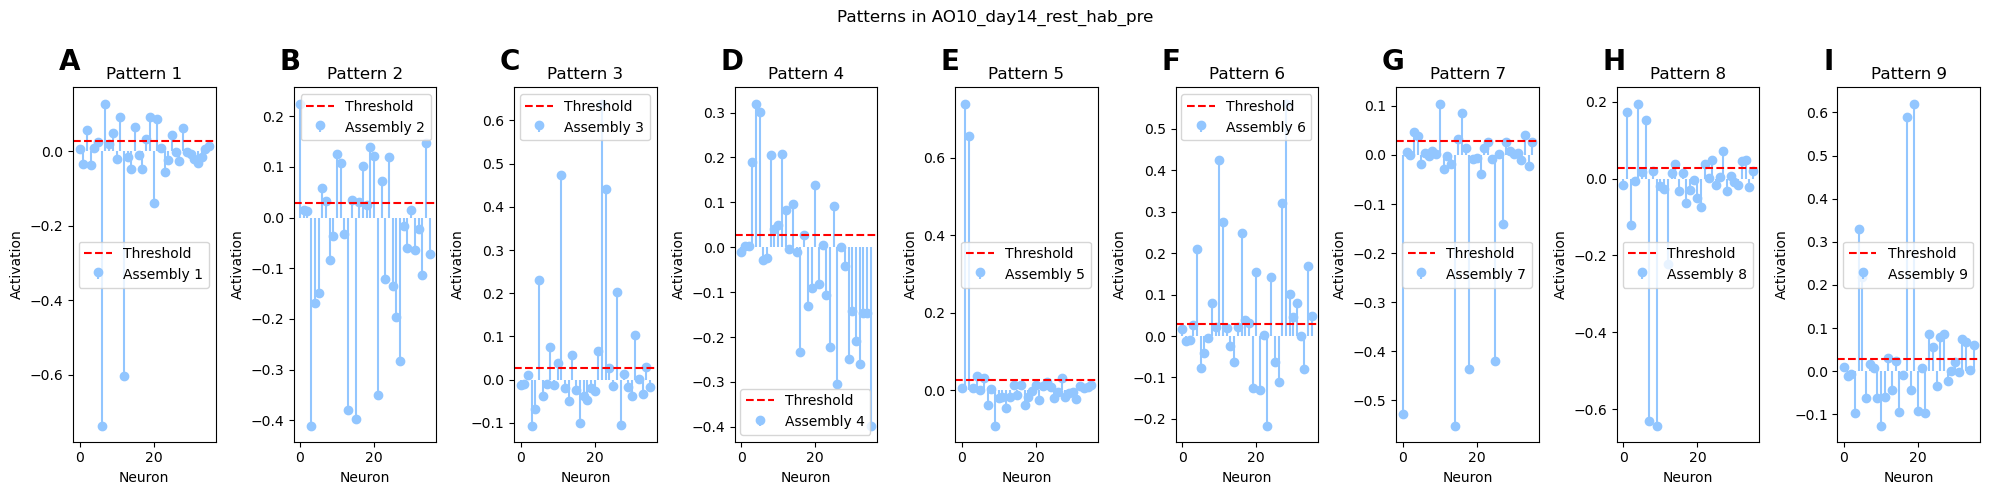

Epoch: AO10_day14_rest_hab_pre, Assembly 1 - Neurons above threshold: [ 2  7  9 11 15 18 19 21 25 28]
Epoch: AO10_day14_rest_hab_pre, Assembly 2 - Neurons above threshold: [ 0  6  7 10 11 14 16 17 19 20 22 24 34]
Epoch: AO10_day14_rest_hab_pre, Assembly 3 - Neurons above threshold: [ 5  8 10 11 14 21 22 23 26 31 34]
Epoch: AO10_day14_rest_hab_pre, Assembly 4 - Neurons above threshold: [ 3  4  5  8  9 10 11 12 14 20 25]
Epoch: AO10_day14_rest_hab_pre, Assembly 5 - Neurons above threshold: [ 1  2  4  6 27]
Epoch: AO10_day14_rest_hab_pre, Assembly 6 - Neurons above threshold: [ 4  8 10 11 16 17 18 20 24 27 28 29 30 31 34 35]
Epoch: AO10_day14_rest_hab_pre, Assembly 7 - Neurons above threshold: [ 3  4 10 15 16 33]
Epoch: AO10_day14_rest_hab_pre, Assembly 8 - Neurons above threshold: [ 1  4  6 14 22 24 27 32 33]
Epoch: AO10_day14_rest_hab_pre, Assembly 9 - Neurons above threshold: [ 4  5 12 17 19 23 24 26 27 32 33 35]


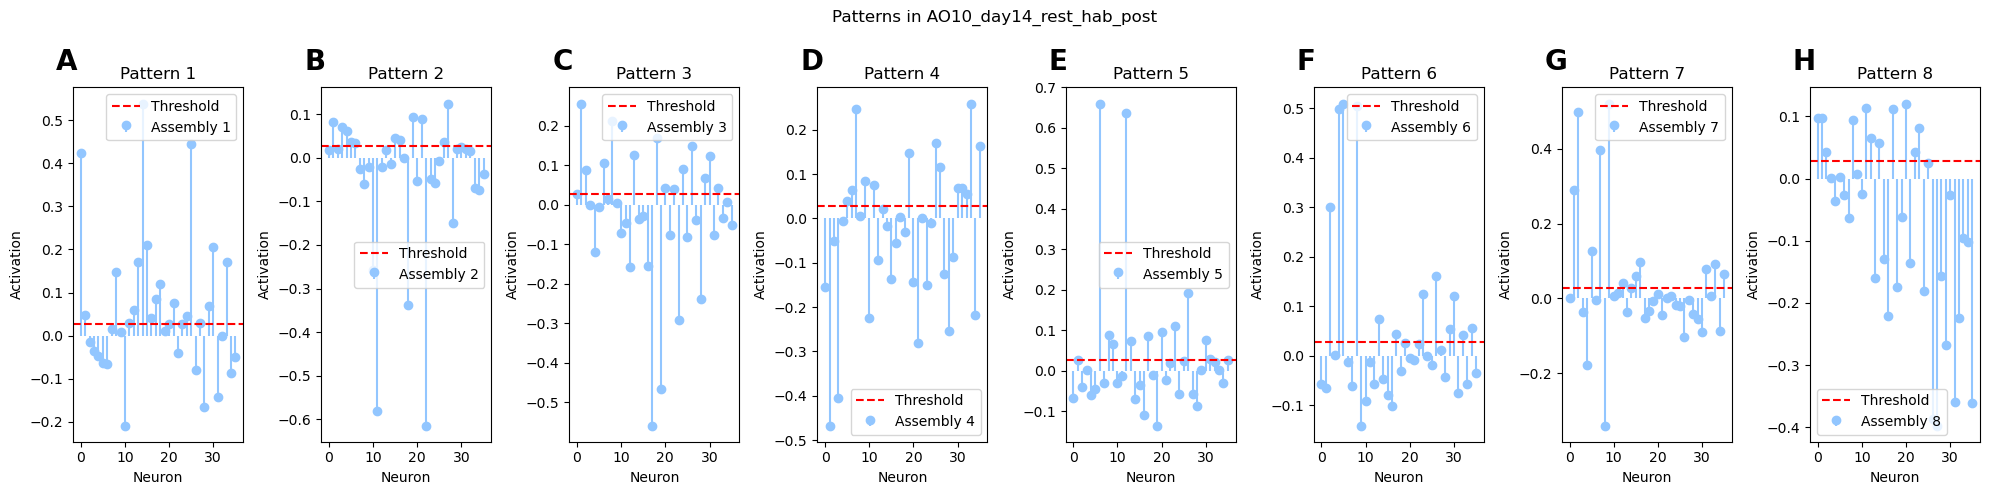

Epoch: AO10_day14_rest_hab_post, Assembly 1 - Neurons above threshold: [ 0  1  8 11 12 13 14 15 16 17 18 21 24 25 27 29 30 33]
Epoch: AO10_day14_rest_hab_post, Assembly 2 - Neurons above threshold: [ 1  3  4  5  6 15 16 19 21 26 27]
Epoch: AO10_day14_rest_hab_post, Assembly 3 - Neurons above threshold: [ 1  2  6  8 13 18 20 22 24 26 29 30 32]
Epoch: AO10_day14_rest_hab_post, Assembly 4 - Neurons above threshold: [ 5  6  7  9 11 19 25 26 30 31 32 33 35]
Epoch: AO10_day14_rest_hab_post, Assembly 5 - Neurons above threshold: [ 6  8  9 12 13 17 20 23 26 30 31]
Epoch: AO10_day14_rest_hab_post, Assembly 6 - Neurons above threshold: [ 2  4  5  8 13 17 23 26 29 30 32 34]
Epoch: AO10_day14_rest_hab_post, Assembly 7 - Neurons above threshold: [ 1  2  5  7  9 12 15 16 31 33 35]
Epoch: AO10_day14_rest_hab_post, Assembly 8 - Neurons above threshold: [ 0  1  2  8 11 12 14 17 20 22 23]


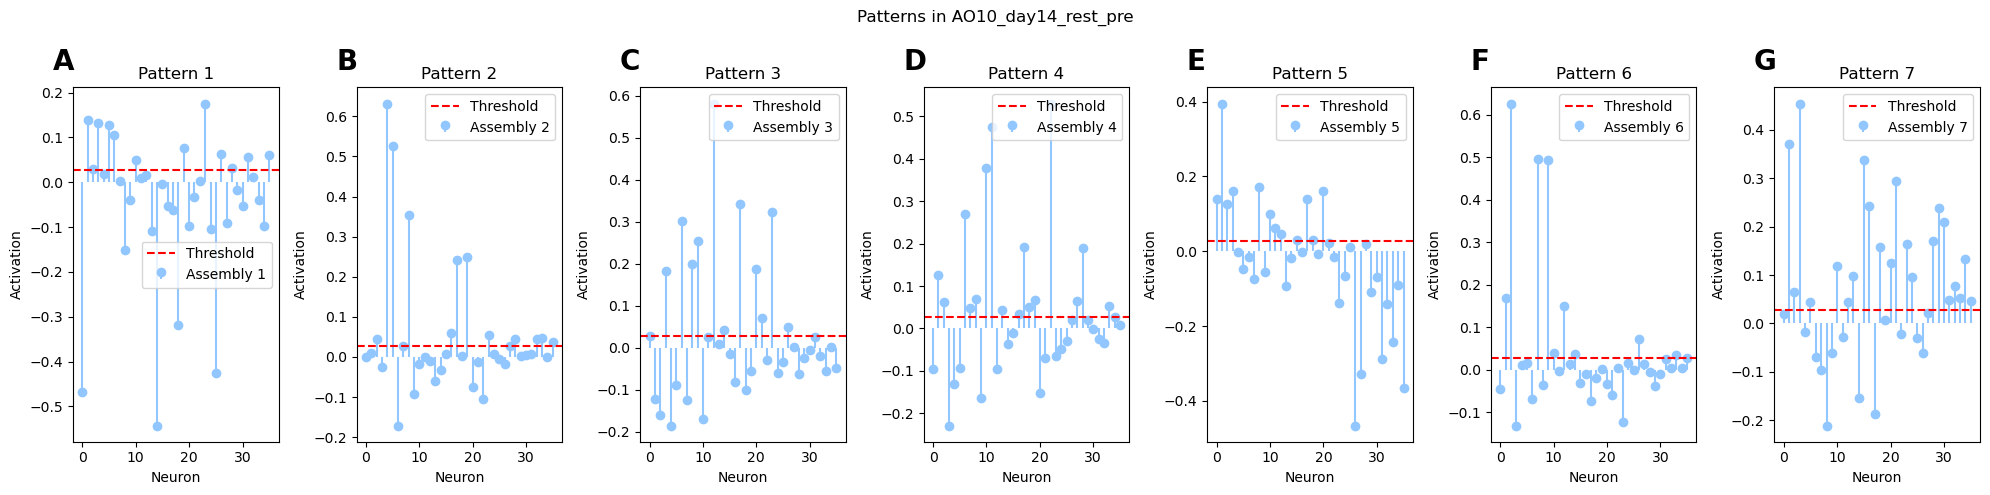

Epoch: AO10_day14_rest_pre, Assembly 1 - Neurons above threshold: [ 1  2  3  5  6 10 19 23 26 28 31 35]
Epoch: AO10_day14_rest_pre, Assembly 2 - Neurons above threshold: [ 2  4  5  8 16 17 19 23 27 28 32 33 35]
Epoch: AO10_day14_rest_pre, Assembly 3 - Neurons above threshold: [ 3  6  8  9 12 14 17 20 21 23 26]
Epoch: AO10_day14_rest_pre, Assembly 4 - Neurons above threshold: [ 1  2  6  7  8 10 11 13 16 17 18 19 22 27 28 33]
Epoch: AO10_day14_rest_pre, Assembly 5 - Neurons above threshold: [ 0  1  2  3  8 10 11 12 15 17 18 20]
Epoch: AO10_day14_rest_pre, Assembly 6 - Neurons above threshold: [ 1  2  7  9 10 12 14 26 33 35]
Epoch: AO10_day14_rest_pre, Assembly 7 - Neurons above threshold: [ 1  2  3  5 10 12 13 15 16 18 20 21 23 24 28 29 30 31 32 33 34 35]


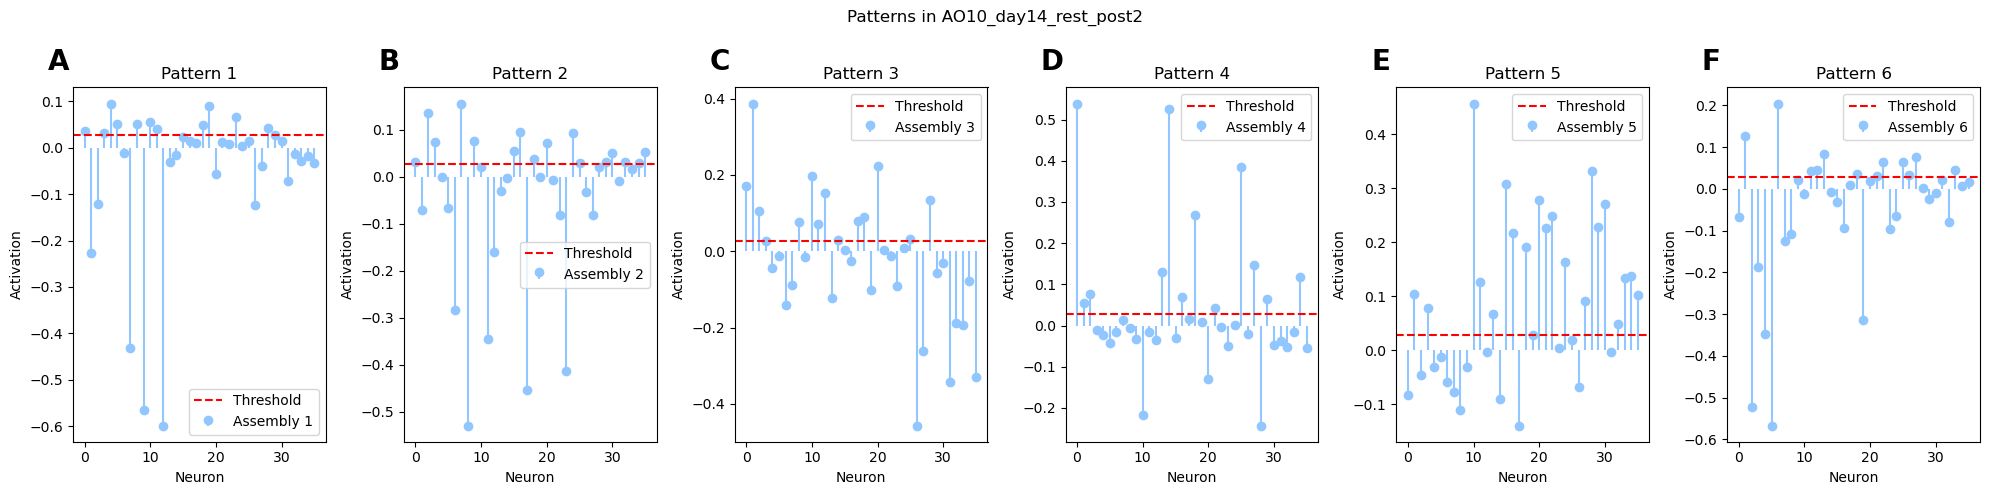

Epoch: AO10_day14_rest_post2, Assembly 1 - Neurons above threshold: [ 0  3  4  5  8 10 11 18 19 23 28]
Epoch: AO10_day14_rest_post2, Assembly 2 - Neurons above threshold: [ 0  2  3  7  9 15 16 18 20 24 25 29 30 32 34 35]
Epoch: AO10_day14_rest_post2, Assembly 3 - Neurons above threshold: [ 0  1  2  8 10 11 12 14 17 18 20 25 28]
Epoch: AO10_day14_rest_post2, Assembly 4 - Neurons above threshold: [ 0  1  2 13 14 16 18 21 25 27 29 34]
Epoch: AO10_day14_rest_post2, Assembly 5 - Neurons above threshold: [ 1  3 10 11 13 15 16 18 19 20 21 22 24 27 28 29 30 32 33 34 35]
Epoch: AO10_day14_rest_post2, Assembly 6 - Neurons above threshold: [ 1  6 11 12 13 18 21 22 25 26 27 33]


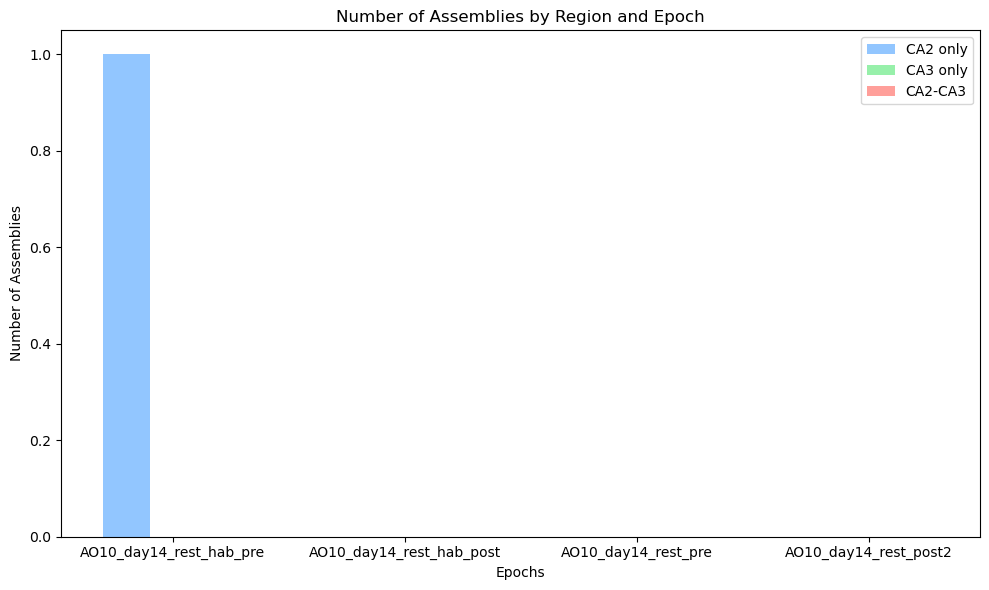

In [145]:
# Plot the assembly activities
plot_assembly_activity(assembly_activities, list(AO10_day14.keys()))
assembly_counts = plot_assembly_patterns(patterns, list(AO10_day14.keys()), AO10_day14_ca2_p, AO10_day14_ca3_p)
plot_assembly_counts(assembly_counts, list(AO10_day14.keys()))

# During Open field epochs

In [146]:
include_epoch = {'AO12_day15_habituation_cage', 'AO12_day15_2novel_exposure', 'AO12_day15_exposure_reversed', 'AO12_day15_1novel_exposure'}
AO12_day15 = dict(filter(lambda item: item[0] in include_epoch, AO12_day15_bins.items()))
assembly_activities = {}
patterns = {}
zactmats = {}

for epoch_name, epoch_data in AO12_day15.items():
    # Run the function for cell assemblies (replace with actual function call and parameters)
    patterns_epoch, significance, zactmat = runPatterns(epoch_data.values.T, method='ica', nullhyp='mp')
    assembly_activity = computeAssemblyActivity(patterns_epoch, zactmat)
    
    # Store results
    assembly_activities[epoch_name] = assembly_activity
    patterns[epoch_name] = patterns_epoch
    zactmats[epoch_name] = zactmat

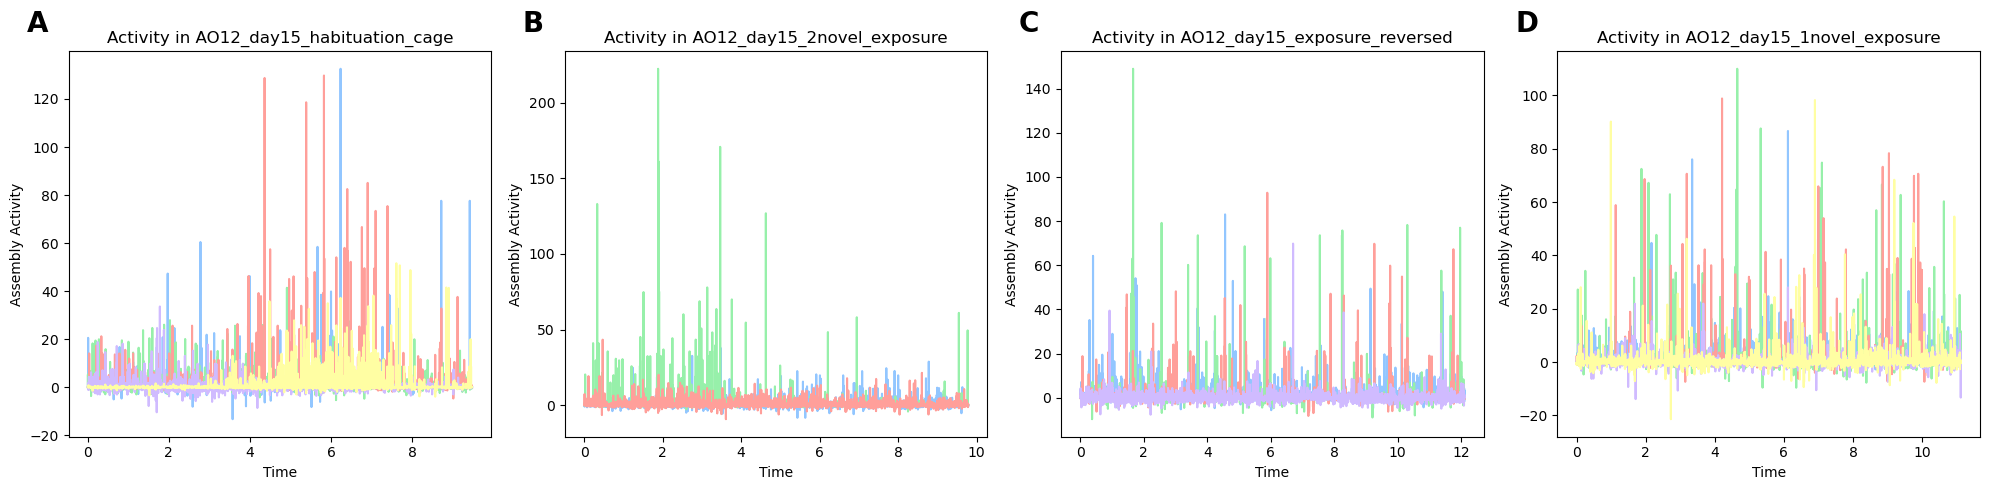

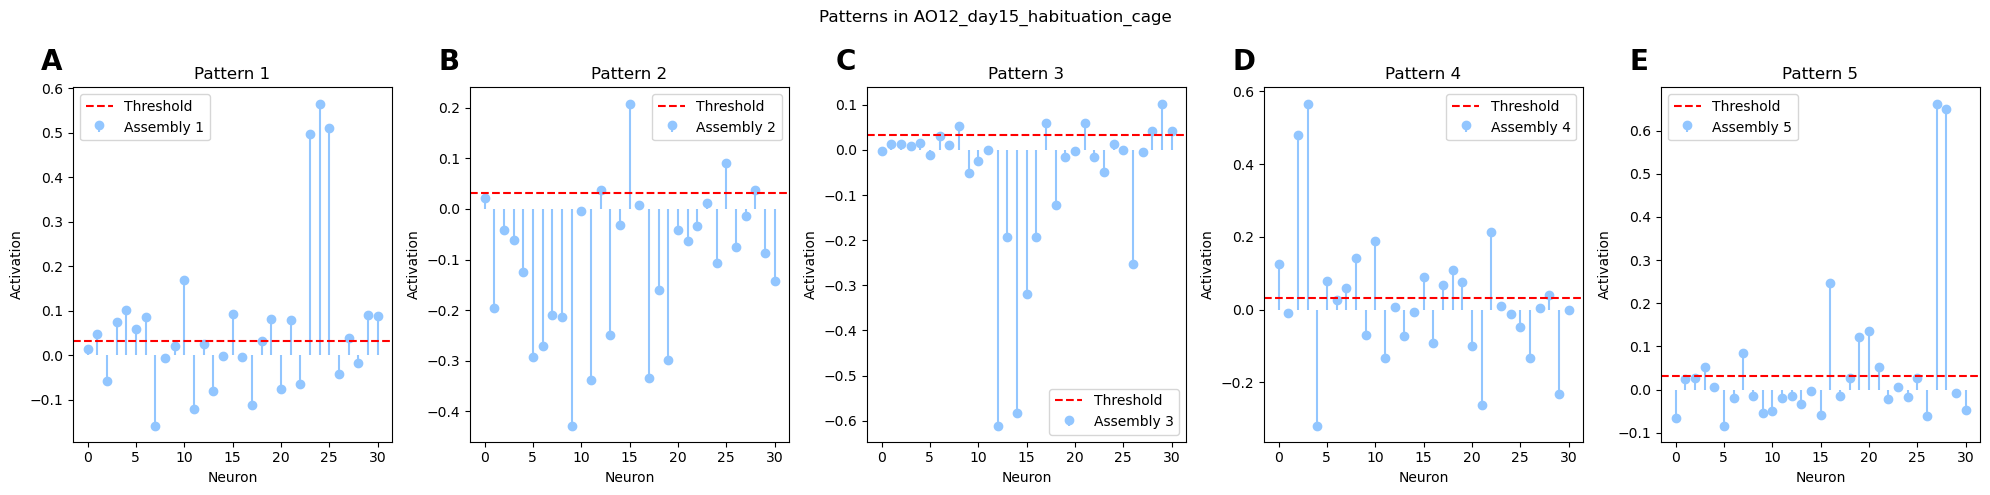

Epoch: AO12_day15_habituation_cage, Assembly 1 - Neurons above threshold: [ 1  3  4  5  6 10 15 19 21 23 24 25 27 29 30]
Epoch: AO12_day15_habituation_cage, Assembly 2 - Neurons above threshold: [12 15 25 28]
Epoch: AO12_day15_habituation_cage, Assembly 3 - Neurons above threshold: [ 8 17 21 28 29 30]
Epoch: AO12_day15_habituation_cage, Assembly 4 - Neurons above threshold: [ 0  2  3  5  7  8 10 15 17 18 19 22 28]
Epoch: AO12_day15_habituation_cage, Assembly 5 - Neurons above threshold: [ 3  7 16 19 20 21 27 28]


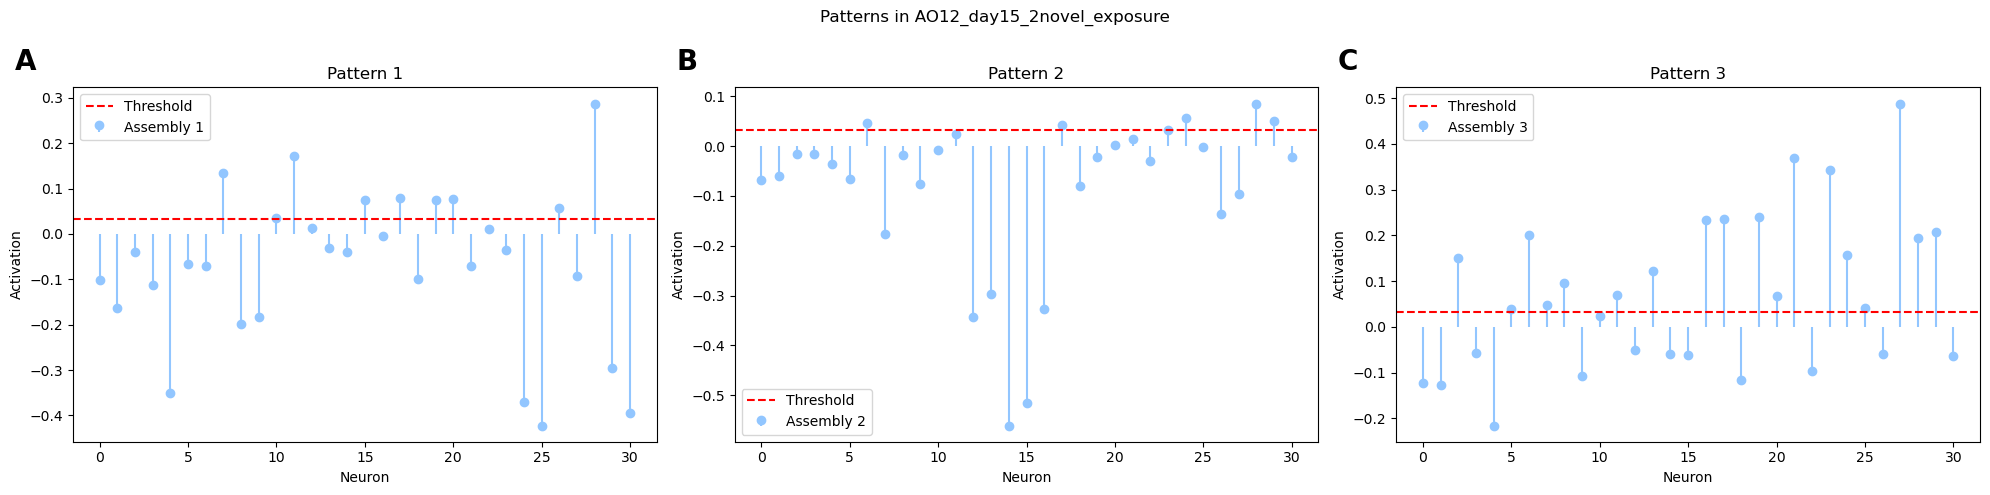

Epoch: AO12_day15_2novel_exposure, Assembly 1 - Neurons above threshold: [ 7 10 11 15 17 19 20 26 28]
Epoch: AO12_day15_2novel_exposure, Assembly 2 - Neurons above threshold: [ 6 17 24 28 29]
Epoch: AO12_day15_2novel_exposure, Assembly 3 - Neurons above threshold: [ 2  5  6  7  8 11 13 16 17 19 20 21 23 24 25 27 28 29]


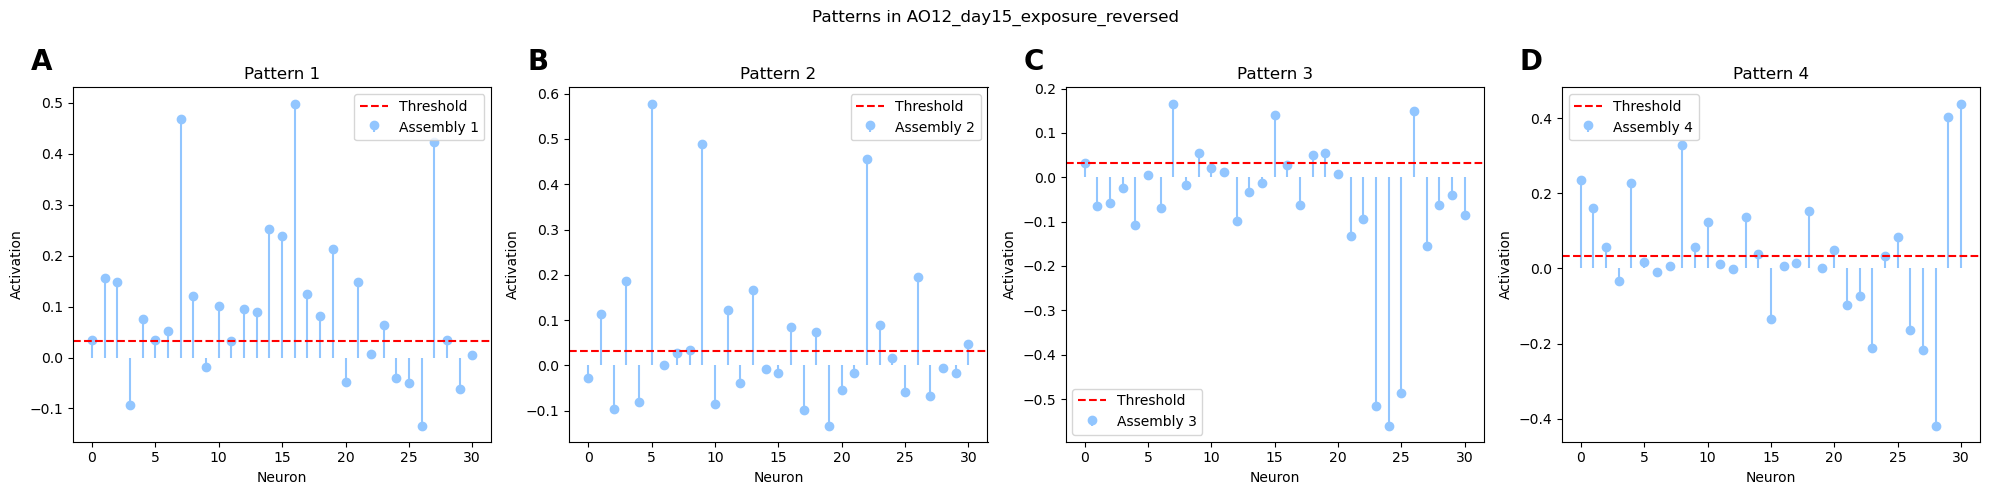

Epoch: AO12_day15_exposure_reversed, Assembly 1 - Neurons above threshold: [ 0  1  2  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 21 23 27 28]
Epoch: AO12_day15_exposure_reversed, Assembly 2 - Neurons above threshold: [ 1  3  5  8  9 11 13 16 18 22 23 26 30]
Epoch: AO12_day15_exposure_reversed, Assembly 3 - Neurons above threshold: [ 0  7  9 15 18 19 26]
Epoch: AO12_day15_exposure_reversed, Assembly 4 - Neurons above threshold: [ 0  1  2  4  8  9 10 13 14 18 20 25 29 30]


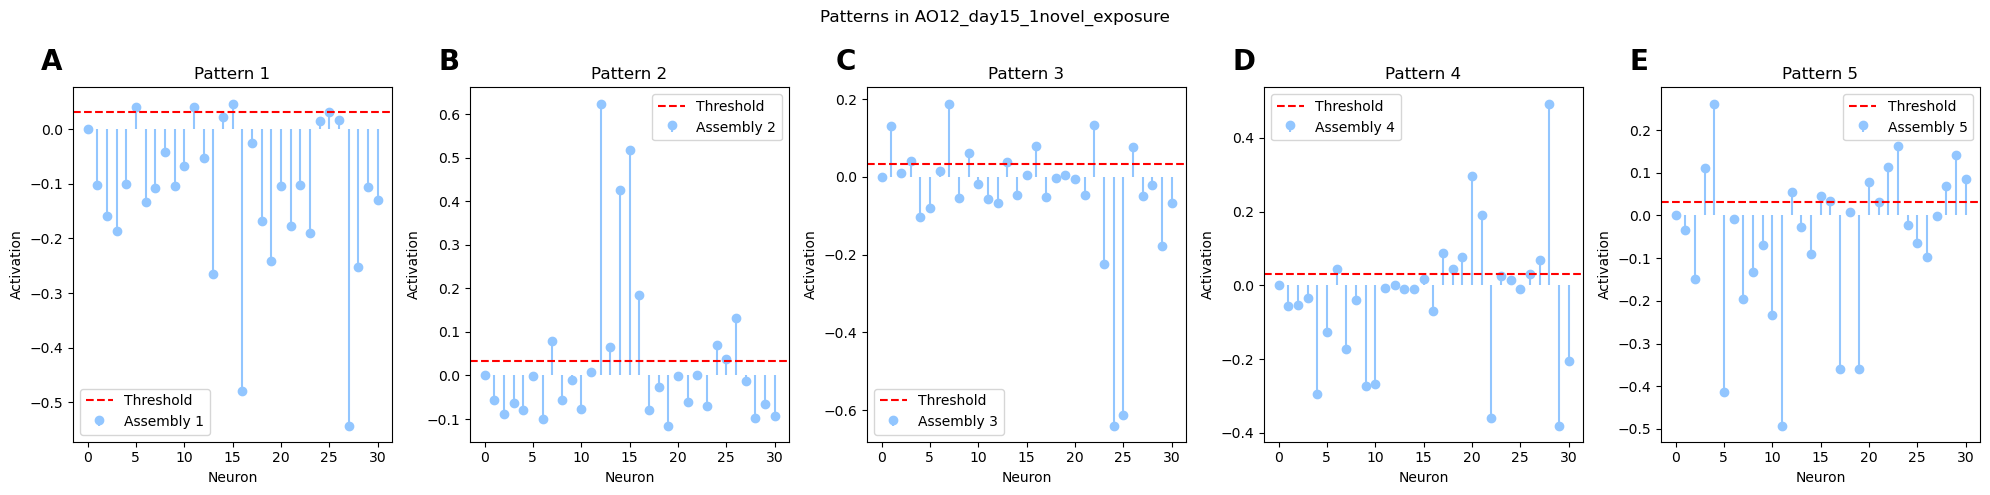

Epoch: AO12_day15_1novel_exposure, Assembly 1 - Neurons above threshold: [ 5 11 15]
Epoch: AO12_day15_1novel_exposure, Assembly 2 - Neurons above threshold: [ 7 12 13 14 15 16 24 25 26]
Epoch: AO12_day15_1novel_exposure, Assembly 3 - Neurons above threshold: [ 1  3  7  9 13 16 22 26]
Epoch: AO12_day15_1novel_exposure, Assembly 4 - Neurons above threshold: [ 6 17 18 19 20 21 27 28]
Epoch: AO12_day15_1novel_exposure, Assembly 5 - Neurons above threshold: [ 3  4 12 15 16 20 22 23 28 29 30]


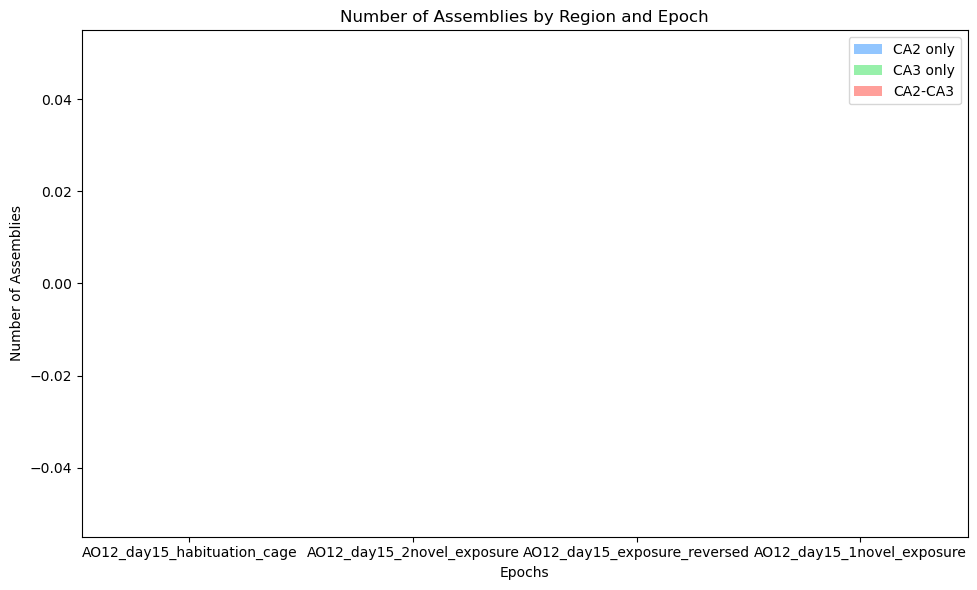

In [147]:
# Plot the assembly activities
plot_assembly_activity(assembly_activities, list(AO12_day15.keys()))
assembly_counts = plot_assembly_patterns(patterns, list(AO12_day15.keys()), AO12_day15_ca2_p, AO12_day15_ca3_p)
plot_assembly_counts(assembly_counts, list(AO12_day15.keys()))